## README

In `newdata_csv`, we have each of the frames (not yet cleaned!) written to a csv. The older csv's end in `'_comments.csv'` (though we now have code that should clean that); the newer ones don't. `incomplete_data.csv` in `dataframes` is the `VIDEO_DF` of only the newer files; `all_data.csv` includes the old files as well.

In [155]:
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from profanityfilter import ProfanityFilter
import string
import warnings

warnings.filterwarnings('ignore')
pf = ProfanityFilter()
%matplotlib inline

## Getting Data/ Categories Set Up

In [81]:
DATA_FOLDER = "data/"
CSV_FOLDER = "newdata_csv/"
DF_FOLDER = "dataframes/"
NEW_FILE_SUFFIX = "_commentsx.pkl"
OLD_FILE_SUFFIX = "_comments.pkl"

In [86]:
CATEGORY_FOLDERS = [x[0][len(DATA_FOLDER):] for x in os.walk('data')][1:]
FOLDER_NAME_MAPPING = {
    'a': 'Apolitical',
    'cp': 'Conspiracy-Pseudoscience',
    'lb': 'Left Bias',
    'lcb': 'Left-Center Bias',
    'pro': 'Pro-Science',
    'pu': 'PragerU',
    'qs': 'Questionable Source',
    'rb': 'Right Bias'
}

total_per_cat = {}
for cat in FOLDER_NAME_MAPPING.keys():
    total_per_cat[cat] = 0

channel_labels_paths = {}       # { name(str) : [ category name (str),
                                #                 path (str) ] }
old_channel_labels_paths = {}
new_channel_labels_paths = {}

LABEL = 0
PATH = 1

for cfolder in CATEGORY_FOLDERS:
    cat_name = FOLDER_NAME_MAPPING[cfolder]
    for r, d, f in os.walk(DATA_FOLDER + cfolder):
        for file in f:
            if NEW_FILE_SUFFIX in str(file):
                channel_labels_paths[file[:-len(NEW_FILE_SUFFIX)]] = [cat_name,
                                                                  DATA_FOLDER + cfolder + '/' + file]
                new_channel_labels_paths[file[:-len(NEW_FILE_SUFFIX)]] = [cat_name,
                                                                  DATA_FOLDER + cfolder + '/' + file]
            elif OLD_FILE_SUFFIX in str(file):
                channel_labels_paths[file[:-len(OLD_FILE_SUFFIX)]] = [cat_name,
                                                                  DATA_FOLDER + cfolder + '/' + file]
                old_channel_labels_paths[file[:-len(OLD_FILE_SUFFIX)]] = [cat_name,
                                                                  DATA_FOLDER + cfolder + '/' + file]
            total_per_cat[cfolder] += 1

In [89]:
print(total_per_cat)

{'a': 2, 'cp': 5, 'lb': 7, 'lcb': 6, 'pro': 1, 'pu': 1, 'qs': 5, 'rb': 8}


In [48]:
tools = []
frames = []

In [47]:
ds_names = sorted(channel_labels_paths.keys())
print(ds_names)

['abc', 'aclu', 'acttv', 'americansforprosperity', 'ammoland', 'autismspeaks', 'bluelivesmatter', 'breaking911', 'coasttocoastAM', 'crooked_media', 'doctoroz', 'ffrf', 'freespeechtv', 'newsbud', 'officialaclj', 'readersdigest', 'scmp', 'sputniknews', 'washingtonexaminer_dc', 'westmonster']


## RUN THIS ONLY IF YOU NEED TO PUT NEW CHANNELS INTO .CSV

In [5]:
class Analyzer(object):
    """Analyzer class"""
    def __init__(self, data_filename, path):
        super(Analyzer, self).__init__()
        self.data_filename = data_filename
        self.path = path
        self.data = self.load_data(self.path)
        self.comments_df = self.get_comments_df()

    def load_data(self, path):
        """Returns data from data folder

        Keyword arguments:
        path -- path to file starting from YouTubeComments folder with extension
        """
        with open(path, 'rb') as f:
            return pickle.load(f)

    def pretty_print_video_data(self, title):
        """Print all comments and metadata of video

        Keyword arguments:
        title -- title of video
        """
        d = self.data
        if title not in d:
            print("Title not found.")

        v_url, video_comments, stats = d[title]

        print("Video Title: %s" % title)
        print("Video URL: %s" % v_url)
        print("Video Metadata: ")
        print("| Publish Date: %s" % stats[0])
        print("| Channel Title: %s" % stats[1])
        print("| Duration: %s" % stats[2])
        print("| View Count: %s" % stats[3])
        print("| Like Count: %s" % stats[4])
        print("| Dislike Count: %s" % stats[5])
        print("| Favorite Count: %s" % stats[6])
        print("")
        for i in range(len(video_comments)):
            comment_dict = video_comments[i]
            print("Comment number %d:" % i)
            print("Author, Timestamp: (%s, %s)" % (comment_dict['original comment'][0][0], comment_dict['original comment'][0][1]))
            print("Like Count: %s" % comment_dict['original comment'][0][2])
            print(comment_dict['original comment'][1])
            print("-------")
            num_replies = len(comment_dict['replies'])
            print("Replies (%d of them)" % num_replies)
            for r in comment_dict['replies'][::-1]:
                print("Author, timestamp: (%s, %s)" % (r[0][0], r[0][1]))
                print("Like Count: %s" % r[0][2])
                print(r[1])
                print("---")
            print("===========")
            print("")

    def pretty_print_first_n(self, n):
        """Pretty print first n videos

        Keyword arguments:
        n -- number of videos to pretty print
        """
        d = self.data
        print("Number of total videos: %d" % len(d))
        for key in list(d.keys())[:n]:
            self.pretty_print_video_data(key)
            print("=====================")
            print("=====================")
            print("")

    def get_comments_df(self):
        """Convert data to pandas dataframe of all comments.
        Returns the pandas comment dataframe
        """
        csv_name = CSV_FOLDER + self.data_filename + ".csv"
        if os.path.isfile(csv_name):
            df = pd.read_csv(csv_name, lineterminator='\n')
            return df

        columns=["Comment", "Author", "Video_Title", "Timestamp",
            "Like_Count", "Is_Reply", "Num_Replies", "Parent"]
        df = pd.DataFrame(columns=columns)
        com_num = 0
        print("Converting Videos to Pandas Dataframe")
        print("Number of videos:")
        print(len(list(self.data.keys())))

        cntr = -1
        for key in self.data:
            cntr += 1
            if cntr % 10 == 0:
                print("completed " + str(cntr))
            v_url, video_comments, stats = self.data[key]
            for comment_dict in video_comments:
                author = comment_dict['original comment'][0][0]
                timestamp = comment_dict['original comment'][0][1]
                like_cnt = comment_dict['original comment'][0][2]
                com_text = comment_dict['original comment'][1]
                is_reply = False
                num_replies = len(comment_dict['replies'])
                df.loc[com_num] = pd.Series({
                    "Comment": com_text,
                    "Author": author,
                    "Video_Title": key,
                    "Timestamp": timestamp,
                    "Like_Count": like_cnt,
                    "Is_Reply": is_reply,
                    "Num_Replies": num_replies
                })
                parent = com_num

                com_num +=1

                for r in comment_dict['replies'][::-1]:
                    author = r[0][0]
                    timestamp = r[0][1]
                    like_cnt = r[0][2]
                    com_text = r[1]
                    is_reply = True
                    num_replies = 0
                    df.loc[com_num] = pd.Series({
                        "Comment": com_text,
                        "Author": author,
                        "Video_Title": key,
                        "Timestamp": timestamp,
                        "Like_Count": like_cnt,
                        "Is_Reply": is_reply,
                        "Num_Replies": num_replies,
                        "Parent": parent
                    })
                    com_num +=1
        df.to_csv(csv_name)
        return df

    def get_duplicates(self):
        """Return Dataframe containing all duplicate comments
        """
        df = self.comments_df
        text = df["Comment"]
        dups = df[text.isin(text[text.duplicated()])].sort_values(by="Comment")
        return dups

    def get_most_replied_comments(self, top_n):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        df = self.comments_df
        top = df.nlargest(top_n, 'Num_Replies')
        top = top.drop_duplicates()
        pd.set_option('max_colwidth',1000)
        return top

    def get_most_liked_comments(self, top_n):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        df = self.comments_df
        top = df.nlargest(top_n, 'Like_Count')
        top = top.drop_duplicates()
        pd.set_option('max_colwidth',1000)
        return top

    def plot_comment_length(self, hide_n):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        df = self.comments_df
        comment_col = df["Comment"]
        comment_lengths = []
        for comm in comment_col:
            if (len(comm) > hide_n):
                comment_lengths.append(len(comm))
        plt.hist(comment_lengths, 100)
        plt.title("Comment Length")
        plt.show()


    def plot_users_vs_replies(self, hide_range=[0,0]):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        users = {}
        d = self.data
        for key in d.keys():
            v_comments = d[key][1]
            for comment in v_comments:
                author = comment['original comment'][0][0]
                if author not in users:
                    users[author] = 0
                num_replies = len(comment['replies'])
                users[author] += num_replies

        values = list(users.values())
        values_nozeroes = []
        ran = list(range(hide_range[0], hide_range[1] + 1))
        for val in values:
            if val not in ran:
                values_nozeroes.append(val)
        plt.hist(values_nozeroes, bins = 'auto')
        plt.ylabel("# of users")
        plt.xlabel("# of comments")
        plt.title("Users versus Total Replies to User")
        plt.show()

    def big_user_comment(self):
        """Plot their # of comments over all the videos and the number of videos they commented on.
        Return the top 30 big users.

        """
        df = self.comments_df
        user_direct = df.loc[df.Parent.isnull()].groupby('Author').count()['Comment']
        user_reply = df.loc[~df.Parent.isnull()].groupby('Author').count()['Comment']
        user = df.groupby('Author').count()['Comment']
        user = pd.DataFrame(user)
        user['user_direct'] = user_direct
        user['user_reply'] = user_reply
        user['Video number']=df[['Author','Video Title']].drop_duplicates().groupby('Author').count()
        user = user.sort_values('Comment',ascending=False)
        user[['user_direct','user_reply','Video number']][:15].plot(kind='bar')
        return user[:15]

    def baby_vader(self):
        df = self.comments_df
        sid = SentimentIntensityAnalyzer()
        score_list=[]
        for i in list(df[:14000].index):
            c = df.iloc[i].Comment
            k = sid.polarity_scores(c)['compound']
            score_list.append(k)

        sns.distplot(score_list,kde=False)

    def pull_conversation_user(self):
        for i in self.comments_df.Parent.unique()[1:]: # be careful, usually the first element is NA
            b = self.comments_df[self.comments_df.Parent==i].groupby('Author').count()['Comment']
            b = pd.DataFrame(b[b>1])
            if len(b)>1:
                b['Parent']=[i]*len(b)
                b['Parent Author'] = [self.comments_df.iloc[int(i)].Author]*len(b)
                try:
                    reply_alot = reply_alot.append(b)
                except NameError:
                    reply_alot = b
        return reply_alot

    
bad_words = pf.get_profane_words()
def is_profane(comment, bad_words):
    prof = {}
    count = 0
    for word in bad_words:
        prof[word.lower()] = True
    for word in comment.split():
        lower = word.lower()
        without_punc = ''.join(ch for ch in lower if ch not in set(string.punctuation))
        if prof.get(lower, False) or prof.get(without_punc, False):
            return 100.0
    return 0.0

In [8]:
#Get Analysis tool for each dataset

# name = list(ds_names)[0]

for name in ds_names:
    print("name: ", name)
    obj = Analyzer(name, channel_labels_paths[name][PATH])
    tools.append(obj)
    print(len(obj.data.keys()))
    frames.append(obj.comments_df[~obj.comments_df.Timestamp.isnull()])

name:  abc
30
name:  aclu
325
name:  acttv
468
name:  americansforprosperity
63
name:  ammoland
165
name:  autismspeaks
237
name:  bluelivesmatter
180
name:  breaking911
127
name:  coasttocoastAM
292
name:  crooked_media
164
name:  doctoroz
49
name:  ffrf
180
name:  freespeechtv
555
name:  newsbud
137
name:  officialaclj
24
name:  readersdigest
519
name:  scmp
13
name:  sputniknews
140
name:  washingtonexaminer_dc
518
name:  westmonster
25


,Unnamed: 0,Comment,Author,Video_Title,Timestamp,Like_Count,Is_Reply,Num_Replies,Parent
0,0,We need the paper towels back from Puerto Rico.,Michael Grajek,Flooding threatens Memorial Day travel across ...,2019-05-25T06:39:37.000Z,25,False,2,NaN
1,1,😂,gdvsevil09,Flooding threatens Memorial Day travel across ...,2019-05-25T23:26:33.000Z,0,True,0,0.0
2,2,@gdvsevil09 🤔🤣🤣🤣,Phillip Finley,Flooding threatens Memorial Day travel across ...,2019-05-26T04:52:36.000Z,0,True,0,0.0
3,3,"Be thankful for what you have ,material things...",Gordon Pearce,Flooding threatens Memorial Day travel across ...,2019-05-25T06:29:50.000Z,8,False,0,NaN
4,4,just imagine how much worse this could be if &...,John Preston,Flooding threatens Memorial Day travel across ...,2019-05-25T00:27:28.000Z,81,False,22,NaN
...,...,...,...,...,...,...,...,...,...
9245,9245,I&#39;m just happy I can contribute to keep hi...,steve119md,Man gets 2 life sentences for kidnapping teen ...,2019-05-25T02:13:27.000Z,0,False,0,NaN
9246,9246,"What’s the point of 2 life sentences , he’ll d...",100O0-qmarq,Man gets 2 life sentences for kidnapping teen ...,2019-05-25T04:34:48.000Z,0,False,2,NaN
9247,9247,Because some states life is 25 years or up yea...,Just Peachy,Man gets 2 life sentences for kidnapping teen ...,2019-05-25T19:24:05.000Z,0,True,0,9246.0
9248,9248,gotcha,100O0-qmarq,Man gets 2 life sentences for kidnapping teen ...,2019-06-01T13:37:58.000Z,0,True,0,9246.0


# Given ALL CSV's, start here

In [59]:
frames = []
dataset_names = []
OLD_CSV_SUFFIX = "_comments.csv"
CSV_SUFFIX = ".csv"

for r, d, f in os.walk(CSV_FOLDER):
    for file in f:
        print(str(file))
        frames += [pd.read_csv(r + str(file), lineterminator='\n')]
        if OLD_CSV_SUFFIX in str(file):
            os.rename(r + str(file), r + str(file)[:-len(OLD_CSV_SUFFIX)] + '.csv')
            dataset_names += [str(file)[:-len(OLD_CSV_SUFFIX)]]
        else:
            dataset_names += [str(file)[:-len(CSV_SUFFIX)]]
print(dataset_names)

abc.csv
aclu.csv
acttv.csv
alex_jones.csv
americansforprosperity.csv
american_renaissance.csv
ammoland.csv
autismspeaks.csv
bbc.csv
bluelivesmatter.csv
breaking911.csv
breitbart.csv
coasttocoastAM.csv
crooked_media.csv
democracy_now.csv
doctoroz.csv
ffrf.csv
fox_news.csv
freespeechtv.csv
newsbud.csv
numberphile.csv
officialaclj.csv
prager_u.csv
readersdigest.csv
russia_today.csv
science_magazine.csv
scmp.csv
sputniknews.csv
syriana_analysis.csv
the_dodo.csv
the_guardian.csv
the_new_york_times.csv
washingtonexaminer_dc.csv
westmonster.csv
young_turks.csv
['abc', 'aclu', 'acttv', 'alex_jones', 'americansforprosperity', 'american_renaissance', 'ammoland', 'autismspeaks', 'bbc', 'bluelivesmatter', 'breaking911', 'breitbart', 'coasttocoastAM', 'crooked_media', 'democracy_now', 'doctoroz', 'ffrf', 'fox_news', 'freespeechtv', 'newsbud', 'numberphile', 'officialaclj', 'prager_u', 'readersdigest', 'russia_today', 'science_magazine', 'scmp', 'sputniknews', 'syriana_analysis', 'the_dodo', 'the_gu

In [74]:
print(len(frames))
print(len(dataset_names))
for i in dataset_names:
    assert channel_labels_paths[i]

35
35


In [61]:
# A little data cleaning
columns=["", "Comment", "Author", "Video Title", "Timestamp","Like Count", "Is Reply", "Num_Replies", "Parent"]
for i in range(len(frames)):
    print(dataset_names[i])
    df = frames[i]
    try:
        df.columns = columns
        df = df.drop([""], axis=1)
        df = df.drop(df[df['Comment'].isnull()].index)
        df = df.drop(df[df['Comment'].apply(lambda x: type(x)!=str)].index)
        df = df.drop(df[df['Like Count'].apply(lambda x: x == 'False')].index)
        df = df.drop(df[df['Like Count'].apply(lambda x: x == 'True')].index)
        df['Like Count'] = df['Like Count'].astype('float').astype('int')
        df['Is Reply'][df[df['Is Reply'].apply(lambda x: x == 'False')].index] = False
        df['Is Reply'][df[df['Is Reply'].apply(lambda x: x == 'True')].index] = True
        df = df.astype({"Like Count": int, "Is Reply": bool, "Num_Replies": int})
        df.insert(1, "Comment Length", df['Comment'].apply(lambda x: len(x)))
        df.insert(2, "Profane", df['Comment'].apply(lambda x: is_profane(x, bad_words)))
        frames[i] = df
    except ValueError:
        print("This is already cleaned.")
frames[0]

abc


/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


aclu
acttv
alex_jones
americansforprosperity
american_renaissance
ammoland
autismspeaks
bbc
bluelivesmatter
breaking911
breitbart
coasttocoastAM
crooked_media
democracy_now
doctoroz
ffrf
fox_news
freespeechtv
newsbud
numberphile
officialaclj
prager_u
readersdigest
russia_today
science_magazine
scmp
sputniknews
syriana_analysis
the_dodo
the_guardian
the_new_york_times
washingtonexaminer_dc
westmonster
young_turks


,Comment,Comment Length,Profane,Author,Video Title,Timestamp,Like Count,Is Reply,Num_Replies,Parent
0,We need the paper towels back from Puerto Rico.,47,0.0,Michael Grajek,Flooding threatens Memorial Day travel across ...,2019-05-25T06:39:37.000Z,25,False,2,NaN
1,😂,1,0.0,gdvsevil09,Flooding threatens Memorial Day travel across ...,2019-05-25T23:26:33.000Z,0,True,0,0.0
2,@gdvsevil09 🤔🤣🤣🤣,16,0.0,Phillip Finley,Flooding threatens Memorial Day travel across ...,2019-05-26T04:52:36.000Z,0,True,0,0.0
3,"Be thankful for what you have ,material things...",102,0.0,Gordon Pearce,Flooding threatens Memorial Day travel across ...,2019-05-25T06:29:50.000Z,8,False,0,NaN
4,just imagine how much worse this could be if &...,213,0.0,John Preston,Flooding threatens Memorial Day travel across ...,2019-05-25T00:27:28.000Z,81,False,22,NaN
...,...,...,...,...,...,...,...,...,...,...
9245,I&#39;m just happy I can contribute to keep hi...,53,0.0,steve119md,Man gets 2 life sentences for kidnapping teen ...,2019-05-25T02:13:27.000Z,0,False,0,NaN
9246,"What’s the point of 2 life sentences , he’ll d...",62,0.0,100O0-qmarq,Man gets 2 life sentences for kidnapping teen ...,2019-05-25T04:34:48.000Z,0,False,2,NaN
9247,Because some states life is 25 years or up yea...,135,0.0,Just Peachy,Man gets 2 life sentences for kidnapping teen ...,2019-05-25T19:24:05.000Z,0,True,0,9246.0
9248,gotcha,6,0.0,100O0-qmarq,Man gets 2 life sentences for kidnapping teen ...,2019-06-01T13:37:58.000Z,0,True,0,9246.0


In [90]:
VIDEO_DF = pd.DataFrame(columns=['Video Title', 'Dataset Name', 'Category', 'Num Views', 'Like Count',
                                 'Dislike Count', 'Profane Rate', 'Num Comments',
                                 'Average Comment Length', 'Average Direct Comment Like Count', 
                                'Average Num Replies', 'Num Unique Authors', 'Comments Per View'])
index = 0
missed = {}
for i, df in enumerate(frames):
    unique_vids = df["Video Title"].unique()
    print(dataset_names[i])
    path = channel_labels_paths[dataset_names[i]][PATH]
    data = pickle.load(open(path, 'rb'))
    
    for vidname in unique_vids:
        try:
            _, _, stats = data[vidname]
            vid = df.loc[df['Video Title'] == vidname]

            numViews = int(stats[3])
            vid_like_count = int(stats[4])
            vid_dislike_count = int(stats[5])
            profane_rate = vid["Profane"].mean()
            num_comments = len(vid)
            avg_comment_length = vid["Comment Length"].mean()

            directs = vid.loc[vid["Is Reply"] == False]
            avg_direct_comment_like_count = directs["Like Count"].mean()
            avg_num_replies = directs["Num_Replies"].mean()
            num_unique_authors = len(vid["Author"].unique())
            comments_per_view = num_comments / numViews

            VIDEO_DF_OLD.loc[index] = [
                vidname,
                dataset_names[i],
                channel_labels_paths[dataset_names[i]][LABEL],
                numViews,
                vid_like_count,
                vid_dislike_count,
                profane_rate,
                num_comments,
                avg_comment_length,
                avg_direct_comment_like_count,
                avg_num_replies,
                num_unique_authors,
                comments_per_view
            ]
            index += 1
        except KeyError:
            try:
                missed[dataset_names[i]][1] += 1
            except:
                missed[dataset_names[i]] = [i, 1]
print(missed)

alex_jones
american_renaissance
bbc
breitbart
democracy_now
fox_news
numberphile
prager_u
russia_today
science_magazine
syriana_analysis
the_dodo
the_guardian
the_new_york_times
young_turks
{'fox_news': [17, 101]}


In [91]:
VIDEO_DF_OLD.to_csv(DF_FOLDER + 'old_data_fox_mistakes.csv')

# MACHINE LEARNING PART
1. Train on old data >> get old data into its own dataframe
2. Test on new data

In [ ]:
VIDEO_DF_OLD = pd.read_csv(DF_FOLDER + 'old_data_fox_mistakes.csv', lineterminator='\n')
VIDEO_DF_NEW = pd.read_csv(DF_FOLDER + 'incomplete_data.csv', lineterminator='\n')
VIDEO_DF = pd.read_csv(DF_FOLDER + 'all_data_fox_mistakes.csv', lineterminator='\n')

### No Split (if you have distinct data you wanna test + train on)

In [171]:
from sklearn import preprocessing

TRAINING_DATA = VIDEO_DF_OLD.drop(['Video Title', 'Dataset Name', 'Category', 'Unnamed: 0'], axis='columns')
TESTING_DATA = VIDEO_DF_NEW.drop(['Video Title', 'Dataset Name', 'Category', 'Unnamed: 0'], axis='columns')
category_encoder = {'Left Bias':0, 'Left-Center Bias':1,'Right Bias':2, 'PragerU':3, 'Conspiracy-Pseudoscience':4,
                   'Pro-Science':5, 'Questionable Source':6, 'Apolitical':7}

TRAIN_LABELS = np.array(VIDEO_DF_OLD['Category'].as_matrix())#.apply(lambda x: category_encoder[x]).as_matrix())
TEST_LABELS = np.array(VIDEO_DF_NEW['Category'].as_matrix())#.apply(lambda x: category_encoder[x]).as_matrix())

In [172]:
data_train = preprocessing.scale(TRAINING_DATA.as_matrix())
data_val = preprocessing.scale(TESTING_DATA.as_matrix())

label_train = TRAIN_LABELS
label_val = TEST_LABELS

print(len(data_train))
print(set(TRAIN_LABELS))
print(set(TEST_LABELS))

2704
{'Left-Center Bias', 'Left Bias', 'Pro-Science', 'Apolitical', 'PragerU', 'Questionable Source', 'Conspiracy-Pseudoscience'}
{'Left-Center Bias', 'Left Bias', 'Right Bias', 'Questionable Source', 'Conspiracy-Pseudoscience'}


### Split (used for if you have just one bunch of data)

In [204]:
from sklearn import preprocessing

TRAINING_DATA = VIDEO_DF.drop(['Video Title', 'Dataset Name', 'Category', 'Unnamed: 0'], axis='columns')
category_encoder = {'Left Bias':0, 'Left-Center Bias':1,'Right Bias':2, 'PragerU':3, 'Conspiracy-Pseudoscience':4,
                   'Pro-Science':5, 'Questionable Source':6, 'Apolitical':7}

TRAIN_LABELS = np.array(VIDEO_DF['Category'].as_matrix())#.apply(lambda x: category_encoder[x]).as_matrix())

In [205]:
# Given X and Y, splits into training and validation data.
def split(data, labels, val_size):
    num_items = len(data)
    assert num_items == len(labels)
    assert val_size >= 0
    if val_size < 1.0:
        val_size = int(num_items * val_size)
    train_size = num_items - val_size
    idx = np.random.permutation(num_items)
    data_train = data[idx][:train_size]
    label_train = labels[idx][:train_size]
    data_val = data[idx][train_size:]
    label_val = labels[idx][train_size:]
    return data_train, data_val, label_train, label_val

train_data = preprocessing.scale(TRAINING_DATA.as_matrix())
data_train, data_val, label_train, label_val = split(train_data, TRAIN_LABELS, 0.15)

In [206]:
print(set(label_train))
print(set(label_val))

{'Left-Center Bias', 'Left Bias', 'Right Bias', 'Apolitical', 'Pro-Science', 'PragerU', 'Questionable Source', 'Conspiracy-Pseudoscience'}
{'Left-Center Bias', 'Left Bias', 'Right Bias', 'Apolitical', 'Pro-Science', 'PragerU', 'Questionable Source', 'Conspiracy-Pseudoscience'}


### Just run these

In [135]:
from sklearn import svm
from sklearn import metrics
def train(X_train, Y_train, C=1.0, _kernel='linear', _gamma=0.1):
    model = svm.SVC(kernel=_kernel, C=C, gamma=_gamma)
    model.fit(X_train, Y_train)
    return model

def cv_experiment(training_data, training_labels, k, C_range, kernel='linear', gammas=[0.1]):
    num_examples = len(training_data)
    idx = np.random.permutation(num_examples)
    x_parts = [None]*k
    y_parts = [None]*k
    part_size = num_examples // k
    for i in range(k):
        si = i * part_size
        if i == k-1:
            ei = num_examples
        else:
            ei = (i+1) * part_size
        x_parts[i] = training_data[idx][si:ei]
        y_parts[i] = training_labels[idx][si:ei]
    assert np.sum(list(map(lambda x: x.shape[0], x_parts))) == num_examples
    assert np.sum(list(map(lambda x: x.shape[0], y_parts))) == num_examples
    results = []
    for C in C_range:
        for g in gammas:
            val_scores = []
            for i in range(0, k):
                X_val, Y_val = x_parts[i], y_parts[i]
                X_train = np.concatenate(x_parts[:i] + x_parts[i+1:], axis=0)
                assert X_train.shape[0] + X_val.shape[0] == num_examples
                Y_train = np.concatenate(y_parts[:i] + y_parts[i+1:], axis=0)
                assert Y_train.shape[0] + Y_val.shape[0] == num_examples
                model = train(X_train, Y_train, C, _kernel=kernel, _gamma = g)
                val_scores.append(metrics.accuracy_score(Y_val, model.predict(X_val)))
            results.append(((C, g), np.mean(val_scores)))
            print("C, g =", results[-1][0], "mean val accuracy: ", results[-1][1])
    return sorted(results, key=lambda x: x[1])[-1]

In [195]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          outname = "CONFUSION_MATRIX"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    classes = sorted(set(np.append(y_true, y_pred)))
    
    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, classes)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig("newest_figures/" + outname)
    return ax
np.set_printoptions(precision=2)

### Get the optimal C and g values for SVM w/ RBF and regular SVM here

In [ ]:
opt_c_g_svm, opt_acc_svm = cv_experiment(data_train, label_train, 5, [0.001, 10, 50, 100, 150, 175, 200, 225, 300, 350, 400, 450])
opt_c_svm = opt_c_g_svm[0]
opt_g_svm = opt_c_g_svm[1]

opt_c_g_rbf, opt_acc_rbf = cv_experiment(data_train, label_train, 5, [0.001, 10, 50, 100, 150, 175, 200, 225, 300, 350, 400, 450], kernel='rbf', gammas=np.arange(0.075, 0.13, 0.005))
opt_c_rbf = opt_c_g_rbf[0]
opt_g_rbf = opt_c_g_rbf[1]

C, g = (0.001, 0.1) mean val accuracy:  0.30501168384879723
C, g = (10, 0.1) mean val accuracy:  0.49758900343642604
C, g = (50, 0.1) mean val accuracy:  0.5042338078874161
C, g = (100, 0.1) mean val accuracy:  0.5074379970544919
C, g = (150, 0.1) mean val accuracy:  0.5062930453280969
C, g = (175, 0.1) mean val accuracy:  0.5074385207003764
C, g = (200, 0.1) mean val accuracy:  0.5074379970544919
C, g = (225, 0.1) mean val accuracy:  0.5078961872034037


# Regular SVM

In [200]:
model = train(data_train, label_train, C=opt_c)

0.49725274725274726
Normalized confusion matrix


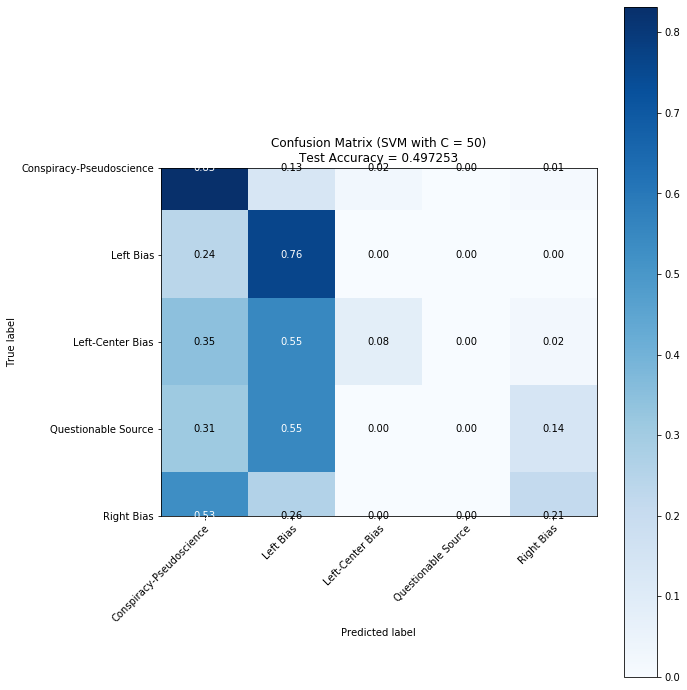

In [201]:
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val), normalize=True,
                      title='Confusion Matrix (SVM with C = %d)\nTest Accuracy = %f' % (opt_c, acc),
                      outname="c=%dSVM.png" % opt_c)

features = ('Num Views', 'Like Count','Dislike Count', 'Profanity Rate', 'Num Comments',
      'Average Comment Length', 'Average Direct Comment Like Count', 
      'Average Thread Length', 'Num Unique Authors', 'Comments Per View')
# for i in range(len(model.coef_[0])):
#     print("Feature %s had the following weights :" % features[i])
#     print(model.coef_[:,i])
#     print()

# SVM w/ RBF

0.5741758241758241
Normalized confusion matrix


{'C': 200,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

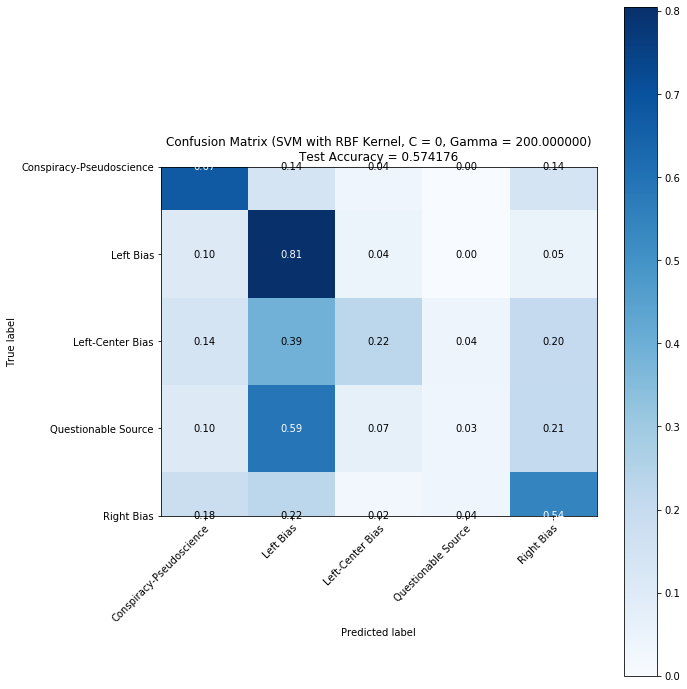

In [202]:
model = train(data_train, label_train, C=opt_c_rbf, _kernel='rbf', _gamma = 0.1)
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val), normalize=True,
                      title='Confusion Matrix (SVM with RBF Kernel, C = %d, Gamma = %f)\nTest Accuracy = %f' % (opt_g_rbf,
                                                                                                                 opt_c_rbf, acc),
                      outname="SVMc=%drbf%d.png" % (opt_c_rbf, opt_g_rbf))

model.get_params(deep=True)

In [203]:
print(np.shape(data_val))

(364, 10)


## Decision Tree Stuff

In [ ]:
import sklearn.tree
def train_tree(X, Y, max_depth):
    model = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X, Y)
    return model

In [ ]:
model = train_tree(data_train, label_train, None)
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val), normalize=True,
                      title='Confusion Matrix (Decision Tree, Max Depth = None)\nTest Accuracy = %f' % acc,
                     outname="decisiontree_maxdepthnone.png")
print(metrics.accuracy_score(label_val, model.predict(data_val)))
print()
for i, feat in enumerate(features):
    print("Importance of %s: " % feat, model.feature_importances_[i])
    print()

In [ ]:
def cv_experiment_tree(training_data, training_labels, k, max_depths):
    num_examples = len(training_data)
    idx = np.random.permutation(num_examples)
    x_parts = [None]*k
    y_parts = [None]*k
    part_size = num_examples // k
    for i in range(k):
        si = i * part_size
        if i == k-1:
            ei = num_examples
        else:
            ei = (i+1) * part_size
        x_parts[i] = training_data[idx][si:ei]
        y_parts[i] = training_labels[idx][si:ei]
    assert np.sum(list(map(lambda x: x.shape[0], x_parts))) == num_examples
    assert np.sum(list(map(lambda x: x.shape[0], y_parts))) == num_examples
    results = []
    for max_depth in max_depths:
        val_scores = []
        for i in range(0, k):
            X_val, Y_val = x_parts[i], y_parts[i]
            X_train = np.concatenate(x_parts[:i] + x_parts[i+1:], axis=0)
            assert X_train.shape[0] + X_val.shape[0] == num_examples
            Y_train = np.concatenate(y_parts[:i] + y_parts[i+1:], axis=0)
            assert Y_train.shape[0] + Y_val.shape[0] == num_examples
            model = train_tree(X_train, Y_train, max_depth)
            val_scores.append(metrics.accuracy_score(Y_val, model.predict(X_val)))
        results.append((max_depth, np.mean(val_scores)))
        print("Max Depth =", results[-1][0], "mean val accuracy: ", results[-1][1])
    return sorted(results, key=lambda x: x[1])[-1][0]

In [ ]:
cv_experiment_tree(data_train, label_train, 5, [None] + list(np.arange(8, 15)))

In [ ]:
model = train_tree(data_train, label_train, 12)
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val),normalize=True,
                      title='Confusion Matrix for Decision Tree (Max Depth = 12)\nTest Accuracy = %f' % acc,
                     outname="decisiontree_maxdepth12.png")
print(metrics.accuracy_score(label_val, model.predict(data_val)))
print()

importance_df = pd.DataFrame(columns=['Feature', 'Decision Tree Importance'])
for i, feat in sorted(enumerate(features), key=lambda x: model.feature_importances_[x[0]]):
    importance_df.loc[i] = [feat, model.feature_importances_[i]]

importance_df

In [ ]:
def plot_result(max_depths, title, filename):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    val_scores = []
    best = float("-inf")
    bestDepth = None
    for depth in max_depths:
        if depth == 0:
            depth = None
        model = train_tree(data_train, label_train, depth)
        acc = metrics.accuracy_score(label_val, model.predict(data_val))
        val_scores.append(acc)
        if acc > best:
            best = acc
            bestDepth = depth
    print(bestDepth, best)
    plt.plot(max_depths, val_scores)
    plt.savefig(filename)

In [ ]:
plot_result(np.arange(0, 40), "Accuracy of Decision Tree with Varying Depth", "newest_figures/decision_tree_acc.png")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def train_forest(X, Y, n_estimators, max_depth):
    model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
    model.fit(X, Y)
    return model

In [ ]:
def cv_experiment_forest(training_data, training_labels, k, n_estimatorss, max_depths):
    num_examples = len(training_data)
    idx = np.random.permutation(num_examples)
    x_parts = [None]*k
    y_parts = [None]*k
    part_size = num_examples // k
    for i in range(k):
        si = i * part_size
        if i == k-1:
            ei = num_examples
        else:
            ei = (i+1) * part_size
        x_parts[i] = training_data[idx][si:ei]
        y_parts[i] = training_labels[idx][si:ei]
    assert np.sum(list(map(lambda x: x.shape[0], x_parts))) == num_examples
    assert np.sum(list(map(lambda x: x.shape[0], y_parts))) == num_examples
    results = []
    for max_depth in max_depths:
        for n_estimators in n_estimatorss:
            val_scores = []
            for i in range(0, k):
                X_val, Y_val = x_parts[i], y_parts[i]
                X_train = np.concatenate(x_parts[:i] + x_parts[i+1:], axis=0)
                assert X_train.shape[0] + X_val.shape[0] == num_examples
                Y_train = np.concatenate(y_parts[:i] + y_parts[i+1:], axis=0)
                assert Y_train.shape[0] + Y_val.shape[0] == num_examples
                model = train_forest(X_train, Y_train, n_estimators, max_depth)
                val_scores.append(metrics.accuracy_score(Y_val, model.predict(X_val)))
            results.append(((n_estimators, max_depth), np.mean(val_scores)))
            print("Num Estimators, Max Depth =", results[-1][0], "mean val accuracy: ", results[-1][1])
    return sorted(results, key=lambda x: x[1])[-1]

In [ ]:
cv_experiment_forest(data_train, label_train, 5, np.arange(11, 110, 10), [None] + list(np.arange(2, 13, 2)))

In [ ]:
model = train_forest(data_train, label_train, 61, None)
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val), normalize=True,
                      title='Confusion Matrix (Random Forest, Max Depth = None, 61 Estimators)\nTest Accuracy = %f' % acc,
                     outname="rf_61-None.png")
importance_df2 = pd.DataFrame(columns=['Feature', 'Decision Tree Importance', 'Random Forest Importance'])
for i, feat in sorted(enumerate(features), key=lambda x: model.feature_importances_[x[0]]):
    importance_df2.loc[i] = [feat, importance_df.loc[importance_df['Feature'] == feat]['Decision Tree Importance'].item(), model.feature_importances_[i]]

importance_df2

In [ ]:
from sklearn.manifold import TSNE
embedded_X = TSNE(n_components=3).fit_transform(train_data)
df_subset = pd.DataFrame(columns=['tsne-3d-one', 'tsne-3d-two', 'tsne-3d-three'])
df_subset['tsne-3d-one'] = embedded_X[:,0]
df_subset['tsne-3d-two'] = embedded_X[:,1]
df_subset['tsne-3d-three'] = embedded_X[:,2]

In [ ]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)
ax.scatter(
    xs=df_subset['tsne-3d-one'], 
    ys=df_subset["tsne-3d-two"], 
    zs=df_subset["tsne-3d-three"], 
    c=[category_encoder[x] for x in LABELS], 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()
plt.savefig("newest_figures/tsne3d.png")

In [ ]:
embedded_X = TSNE(n_components=2).fit_transform(train_data)
df_subset = pd.DataFrame(columns=['tsne-2d-one', 'tsne-2d-two'])
df_subset['tsne-2d-one'] = embedded_X[:,0]
df_subset['tsne-2d-two'] = embedded_X[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=LABELS,
    palette=sns.color_palette("hls", 8),
    data=df_subset,
    legend="full",
    alpha=0.8
)
plt.savefig("newest_figures/tsne2d.png")